<a href="https://colab.research.google.com/github/HanbumKo/DRL-course/blob/main/2_DQN/2_2_DQN_Pong.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DQN**

이번 노트북에서는 Atari의 Pong 환경에서 DQN을 구현해보겠습니다.

In [1]:
"""
Reference
https://github.com/higgsfield/RL-Adventure/blob/master/1.dqn.ipynb
https://github.com/higgsfield/RL-Adventure/blob/master/common/wrappers.py
https://github.com/openai/baselines/blob/master/baselines/common/atari_wrappers.py
"""

'\nReference\nhttps://github.com/higgsfield/RL-Adventure/blob/master/1.dqn.ipynb\nhttps://github.com/higgsfield/RL-Adventure/blob/master/common/wrappers.py\nhttps://github.com/openai/baselines/blob/master/baselines/common/atari_wrappers.py\n'

구현에 필요한 라이브러리들을 import 합니다.

In [2]:
import gym
import cv2
import torch
import random
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from gym import spaces

jupyter notebook에서 matplotlib을 사용하기 위해 필요한 함수도 import합니다.

In [3]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

# Wrapper

DQN 논문에서 사용된 전처리 과정을 편하게 사용할 수 있도록 도와주는 클래스와 함수들입니다.

OpenAI의 gym 환경을 사용할 경우, 존재하는 환경을 원하는 부분만 변경해줄 수 있습니다.

Wrapper 클래스를 정의하고 (gym.Wrapper를 상속받아 구현합니다.)

```
existingEnv = gym.make("env-name")
new_env = exampleWrapper(existingEnv)
```

와 같은 식으로 환경에 Wrapper를 씌워 수정할 수 있습니다.

gym.ObservationWrapper, gym.RewardWrapper와 같이 observation이나 reward만을 수정할 수도 있고, gym.Wrapper를 통해 한꺼번에 수정할 수도 있습니다.

이곳에서 사용하는 Wrapper에 대한 설명은 다음과 같습니다.

NoopResetEnv : Atari에서 게임 시작 시 첫 30-40프레임 정도는 가만히 있는 경우가 있어 이 부분을 스킵하게 도와주는 Wrapper입니다.

MaxAndSkipEnv : DQN 논문에서 사용하는 매 4-step씩은 같은 action으로 진행하며, 4 프레임 중 마지막 두 프레임은 합치도록 도와주는 Wrapper입니다.

EpisodicLifeEnv : Episode의 끝을 한 번 죽거나 스코어가 나는것이 아닌 모든 life나 게임이 아예 끝날때로 바꿔주는 Wrapper입니다. (Pong에서는 똑같습니다)

WarpFrame : Atari의 원래의 이미지 크기인 (210, 160) 사이즈의 이미지를 (84, 84)로 바꿔주는 Wrapper입니다.

ClipRewardEnv : DQN 논문에서 사용한 것과 같이 리워드가 0 이상이면 1로, 0이면 0, 0 이하이면 -1로 부호만을 받도록 리워드를 설정해주는 Wrapper입니다.

ImageToPyTorch : 환경에서 반환되는 state 이미지는 (210, 160, 3)로서 channel이 가장 뒤쪽에 나오도록 되있는데, 이것을 PyTorch에서 사용하기 위해 (3, 210, 160)으로 변경해주는 Wrapper입니다.

In [4]:
class NoopResetEnv(gym.Wrapper):
    def __init__(self, env, noop_max=30):
        """Sample initial states by taking random number of no-ops on reset.
        No-op is assumed to be action 0.
        """
        gym.Wrapper.__init__(self, env)
        self.noop_max = noop_max
        self.override_num_noops = None
        self.noop_action = 0
        assert env.unwrapped.get_action_meanings()[0] == 'NOOP'

    def reset(self, **kwargs):
        """ Do no-op action for a number of steps in [1, noop_max]."""
        self.env.reset(**kwargs)
        if self.override_num_noops is not None:
            noops = self.override_num_noops
        else:
            noops = self.unwrapped.np_random.randint(1, self.noop_max + 1) #pylint: disable=E1101
        assert noops > 0
        obs = None
        for _ in range(noops):
            obs, _, done, _ = self.env.step(self.noop_action)
            if done:
                obs = self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

In [5]:
class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = np.zeros((2,)+env.observation_space.shape, dtype=np.uint8)
        self._skip       = skip

    def reset(self):
        return self.env.reset()

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if i == self._skip - 2: self._obs_buffer[0] = obs
            if i == self._skip - 1: self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame
        # doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

In [6]:
class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done  = True

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            # for Qbert sometimes we stay in lives == 0 condtion for a few frames
            # so its important to keep lives > 0, so that we only reset once
            # the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, info

    def reset(self, **kwargs):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs

In [7]:
class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env):
        """Warp frames to 84x84 as done in the Nature paper and later work."""
        gym.ObservationWrapper.__init__(self, env)
        self.width = 84
        self.height = 84
        self.observation_space = spaces.Box(low=0, high=255,
            shape=(self.height, self.width, 1), dtype=np.uint8)

    def observation(self, frame):
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, (self.width, self.height), interpolation=cv2.INTER_AREA)
        return frame[:, :, None]

In [8]:
class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward):
        """Bin reward to {+1, 0, -1} by its sign."""
        return np.sign(reward)

In [9]:
class ImageToPyTorch(gym.ObservationWrapper):
    """
    Image shape to num_channels x weight x height
    """
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(old_shape[-1], old_shape[0], old_shape[1]), dtype=np.uint8)

    def observation(self, observation):
        return np.swapaxes(observation, 2, 0)

In [10]:
def make_atari(env_id):
    env = gym.make(env_id)
    assert 'NoFrameskip' in env.spec.id
    env = NoopResetEnv(env, noop_max=30)
    env = MaxAndSkipEnv(env, skip=4)
    return env

In [11]:
def wrap_deepmind(env, episode_life=True, clip_rewards=True):
    """Configure environment for DeepMind-style Atari.
    """
    if episode_life:
        env = EpisodicLifeEnv(env)
    env = WarpFrame(env)
    if clip_rewards:
        env = ClipRewardEnv(env)
    return env


In [12]:
def wrap_pytorch(env):
    return ImageToPyTorch(env)

# Replay Buffer

In [13]:
class ReplayBuffer:
    """
    https://github.com/openai/spinningup/blob/master/spinup/algos/pytorch/ddpg/ddpg.py
    """
    def __init__(self, obs_shape, act_shape, buffer_size):
        buffer_obs_shape = tuple([buffer_size]) + obs_shape
        buffer_act_shape = tuple([buffer_size]) + act_shape
        self.obs_buf = np.zeros(buffer_obs_shape, dtype=np.float32)
        self.obs2_buf = np.zeros(buffer_obs_shape, dtype=np.float32)
        self.act_buf = np.zeros(buffer_act_shape, dtype=np.float32)
        self.rew_buf = np.zeros(buffer_size, dtype=np.float32)
        self.done_buf = np.zeros(buffer_size, dtype=np.float32)
        self.pointer, self.size, self.buffer_size = 0, 0, buffer_size

    def store(self, obs, act, rew, next_obs, done):
        self.obs_buf[self.pointer] = obs
        self.obs2_buf[self.pointer] = next_obs
        self.act_buf[self.pointer] = act
        self.rew_buf[self.pointer] = rew
        self.done_buf[self.pointer] = done
        self.pointer = (self.pointer+1) % self.buffer_size
        self.size = min(self.size+1, self.buffer_size)

    def sample_batch(self, batch_size=32):
        idxs = np.random.randint(0, self.size, size=batch_size)
        batch = dict(obs=self.obs_buf[idxs],
                     obs2=self.obs2_buf[idxs],
                     act=self.act_buf[idxs],
                     rew=self.rew_buf[idxs],
                     done=self.done_buf[idxs])
        return {k: torch.as_tensor(v, dtype=torch.float32) for k,v in batch.items()}

    def __len__(self):
        return self.size

# Model

DQN 논문에서 사용하는 모델입니다. CNN + linear를 통해 action의 갯수만큼을 모델의 아웃풋으로 내어줍니다.

In [14]:
class DQNPong(nn.Module):
    def __init__(self, channel_dim, n_actions, device):
        super(DQNPong, self).__init__()
        
        self.channel_dim = channel_dim
        self.n_actions = n_actions
        self.device = device

        self.c1 = nn.Conv2d(channel_dim, 32, kernel_size=8, stride=4)
        self.c2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.c3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        
        self.l1 = nn.Linear(3136, 512)
        self.l2 = nn.Linear(512, n_actions)
        
    def forward(self, x):
        x = F.relu(self.c1(x))
        x = F.relu(self.c2(x))
        x = F.relu(self.c3(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.l1(x))
        x = self.l2(x)

        return x
    
    def get_action(self, obs, epsilon=0):
        if isinstance(obs, np.ndarray):
            obs = torch.tensor(obs, dtype=torch.float32)
        obs = torch.unsqueeze(obs, 0) # (1, 84, 84) -> (1, 1, 84, 84)
        obs = obs.to(self.device)
        if random.random() > epsilon:
            with torch.no_grad():
                q = self.forward(obs)
                action = torch.argmax(q).item()
        else:
            action = random.randrange(self.n_actions)

        return action


# Test

모델과 환경을 파라미터로 받아 한 에피소드를 테스트하는 함수입니다. 에피소드의 리워드를 구하여 반환해줍니다.

In [15]:
def test(target_q_model, env):
    test_episode_reward = 0
    obs = env.reset()
    while True:
        action = target_q_model.get_action(obs, 0)
        next_obs, rew, done, _ = env.step(action)
        test_episode_reward += rew
        obs = next_obs
        if done:
            break

    return test_episode_reward

# Train

Replay Buffer에서 가져온 batch data로 모델을 업데이트 하는 함수입니다. target q value와 q value 사이의 TD error를 반환합니다.

In [16]:
def train(q_model, target_q_model, batch, optim, gamma):
    obs = batch["obs"].to(device)
    next_obs = batch["obs2"].to(device)
    act = torch.tensor(batch["act"], dtype=torch.int64).to(device)
    rew = batch["rew"].to(device)
    done = batch["done"].to(device)

    obs_output = q_model(obs)
    q = torch.gather(obs_output, 1, act).squeeze(1)

    with torch.no_grad():
        next_obs_output = target_q_model(next_obs)
        next_q = torch.max(next_obs_output, dim=1)[0]

    td_target = rew + gamma * next_q * (1-done)
    td_error = (q - td_target).pow(2).mean()

    optim.zero_grad()
    td_error.backward()
    optim.step()

    return td_error.item()

# Matplotlib

plot() 함수에서는 test reward와, train reward, TD error, epsilon이 감소하는 것을 보여주고,

show_image()함수에서는 이미지를 받아 jupyter notebook에서 확인할 수 있도록 보여줍니다.

In [17]:
def plot(test_rewards, train_rewards, td_errors, epsilons):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(231)
    plt.title('test reward')
    plt.plot(test_rewards)
    plt.subplot(232)
    plt.title('TD error')
    plt.plot(td_errors)
    plt.subplot(234)
    plt.title('train reward')
    plt.plot(train_rewards)
    plt.subplot(235)
    plt.title('epsilon')
    plt.plot(epsilons)
    plt.show()

In [18]:
def show_image(image):
    clear_output(True)
    plt.imshow(image)
    plt.show()

# Epsilon

현재 time step을 파라미터로 받아서 사용할 epsilon을 반환해주는 함수입니다. DQN 논문에서와 같이 1부터 0.1까지 linear하게 감소됩니다.

In [19]:
epsilon_start = 1.0
epsilon_final = 0.1
epsilon_decay = 30000

def get_epsilon(frame_idx):
    dec_size = (epsilon_start - epsilon_final) / epsilon_decay

    return max(epsilon_start - dec_size * frame_idx, epsilon_final)


# Main

트레이닝에 필요한 환경, 모델, loss, optimizer 등등을 정의하는 코드입니다. target q model은 q model과 같아지도록 복사해줍니다.

In [20]:
# Save device (cpu or cuda)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Make env
train_env = make_atari("PongNoFrameskip-v4")
train_env = wrap_deepmind(train_env)
train_env = wrap_pytorch(train_env)
test_env = make_atari("PongNoFrameskip-v4")
test_env = wrap_deepmind(test_env)
test_env = wrap_pytorch(test_env)

# shape
obs_shape = train_env.observation_space.shape # (1, 84, 84)
n_actions = train_env.action_space.n # 6
act_shape = tuple([1]) # int to Tuple
channel_dim = obs_shape[0] # 1
buffer_size = 100000

# Define NN
q_model = DQNPong(channel_dim=channel_dim, n_actions=n_actions, device=device)
target_q_model = DQNPong(channel_dim=channel_dim, n_actions=n_actions, device=device)
q_model.to(device)
target_q_model.to(device)

# Copy weight
target_q_model.load_state_dict(q_model.state_dict())

# Buffer & optimizer
replay_buffer = ReplayBuffer(obs_shape, act_shape, buffer_size)
optimizer = optim.RMSprop(q_model.parameters(), lr=0.00001)

# training parameters - this is not exactly same as DQN model
total_step = 2000000
batch_size = 32
gamma = 0.99
copy_freq = 3000

# lists for saving results
test_rewards = []
train_rewards = []
td_errors = []
epsilons = []

DQN 트레이닝을 실행하는 메인 루프입니다. total_step만큼 돌면서 매 스텝마다 (S, A, R, S', done)을 Replay Buffer에 넣어주고 batch size 이상이 되면 불러와 한 번 웨이트를 업데이트 실행합니다. 매 10,000스텝 마다 테스트를 실행하며 3,000 스텝마다 target q model을 업데이트 해줍니다.

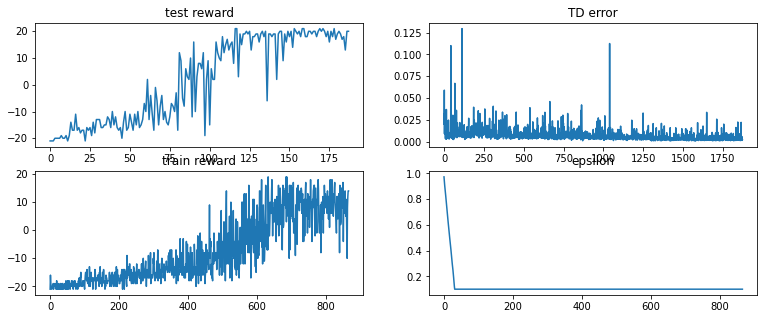

1873668


KeyboardInterrupt: ignored

In [21]:
episode_reward = 0
best_test_reward = -999999
obs = train_env.reset()
for t in range(total_step):
    action = q_model.get_action(obs, get_epsilon(t))
    next_obs, rew, done, _ = train_env.step(action)
    replay_buffer.store(obs, action, rew, next_obs, done)
    episode_reward += rew
    obs = next_obs

    if done:
        # print("episode_reward :", episode_reward, t)
        train_rewards.append(episode_reward)
        epsilons.append(get_epsilon(t))
        plot(test_rewards, train_rewards, td_errors, epsilons)
        print(t)
        obs = train_env.reset()
        episode_reward = 0

    # Train
    if len(replay_buffer) > batch_size:
        sampled_batch = replay_buffer.sample_batch(batch_size=batch_size)
        td_error = train(q_model, target_q_model, sampled_batch, optimizer, gamma)
        if t % 1000 == 0:
            td_errors.append(td_error)
    
    # Test
    if t % 10000 == 0:
        test_reward = test(q_model, test_env)
        test_rewards.append(test_reward)
        # print("test reward :", test_reward)
        if best_test_reward <= test_reward:
            best_test_reward = test_reward
            torch.save(q_model.state_dict(), "q_model.pt")
            torch.save(target_q_model.state_dict(), "target_q_model.pt")

    if t % copy_freq == 0:
        target_q_model.load_state_dict(q_model.state_dict())

# Render

저장된 q model을 불러와 트레이닝이 잘 진행됐는지 이미지로 확인합니다.

오른쪽이 트레이닝 된 에이전트로, 잘 학습되어 공을 잘 넘기는 것을 확인할 수 있습니다.

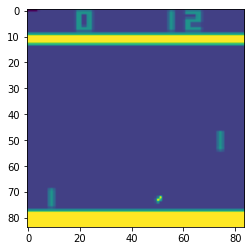

In [22]:
#Show the image with matplotlib
q_model.load_state_dict(torch.load("q_model.pt"))
obs = test_env.reset()
for i in range(1000):
    show_image(np.transpose(obs.squeeze()))
    action = q_model.get_action(obs, 0)
    obs, _, done, _ = test_env.step(action)
    if done:
        break